# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence from previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost.


In [6]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim

In [7]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

MessageError: Error: credential propagation was unsuccessful

In [ ]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Split Data

In [ ]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


In [5]:
data.pop('Date_vaw')
Train = data[:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(len(Test))

NameError: name 'data' is not defined

In [ ]:
fragment_size = 10
step = 1

# Create fragmented training data
Train_Fragmented = [Train.iloc[i:i + fragment_size] for i in range(0, len(Train) - fragment_size, step)]
Train_Labels = [Train.iloc[i + fragment_size][['Close_vaw', 'Close_vgt', 'Close_vfh', 'Close_vde', 'Close_vht', 'Close_vnq']] for i in range(0, len(Train) - fragment_size, step)]

# Since we want the label to be the element at fragment_size+1, pop the first element
Train_Fragmented.pop(0)
Train_Labels.pop(0)

# Create fragmented testing data
Test_Fragmented = [Test.iloc[i:i + fragment_size] for i in range(0, len(Test) - fragment_size, step)]
Test_Labels = [Test.iloc[i + fragment_size][['Close_vaw', 'Close_vgt', 'Close_vfh', 'Close_vde', 'Close_vht', 'Close_vnq']] for i in range(0, len(Test) - fragment_size, step)]

# Since we want the label to be the element at fragment_size+1, pop the first element
Test_Fragmented.pop(0)
Test_Labels.pop(0)

# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')




Number of Train Fragments: 2549
Number of Train Labels: 2549
Number of Test Fragments: 630
Number of Test Labels: 630


In [ ]:

fragment_size = 10;
step = 1
Train_Fragmented = [Train.iloc[i:i + fragment_size] for i in range(0, len(Train), step)]
Train_Labels = [Train.iloc[i][['Close_vaw','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Train), step)]


Train_Labels.pop(0)


Test_Fragmented = [Test.iloc[i:i + fragment_size] for i in range(0, len(Test)-1, step)]
Test_Labels = [Test.iloc[i][['Close_vaw','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Test), step)]

Train_Labels.append(Test_Labels.pop(0))


print(Train_Fragmented[254]['Close_vaw'])
print(Train_Labels[254])
print(Train_Fragmented[255]['Close_vaw'])
print(Train_Labels[255])

print(Test_Fragmented[0]['Close_vaw'])
print(Test_Labels[0])
print(Test_Fragmented[1]['Close_vaw'])
print(Test_Labels[1])

print(Test_Fragmented[62]['Close_vaw'])
print(Test_Labels[62])
print(Test_Fragmented[63]['Close_vaw'])
print(Test_Labels[63])

254    56.595
255    56.971
256    57.051
257    56.263
258    55.649
259    55.317
260    55.157
261    56.068
262    56.237
263    57.105
Name: Close_vaw, dtype: float64
Close_vaw    56.971
Close_vgt    47.637
Close_vfh    50.843
Close_vde    67.447
Close_vht    51.527
Close_vnq    49.901
Name: 255, dtype: float64
255    56.971
256    57.051
257    56.263
258    55.649
259    55.317
260    55.157
261    56.068
262    56.237
263    57.105
264    57.925
Name: Close_vaw, dtype: float64
Close_vaw    57.051
Close_vgt    47.357
Close_vfh    50.634
Close_vde    67.596
Close_vht    51.463
Close_vnq    49.634
Name: 256, dtype: float64
2560    105.18
2561    106.88
2562    106.66
2563    105.42
2564    105.50
2565    105.89
2566    107.32
2567    106.94
2568    105.92
2569    105.96
Name: Close_vaw, dtype: float64
Close_vaw    106.880
Close_vgt    105.430
Close_vfh     47.062
Close_vde    108.180
Close_vht    129.780
Close_vnq     71.749
Name: 2561, dtype: float64
2561    106.88
2562    106.66

In [ ]:
print(len(Train_Fragmented))
print(len(Train_Labels))
print(len(Test_Fragmented))
print(len(Test_Labels))


2560
2560
640
640


2565    105.38
2566    106.73
2567    107.18
2568    106.59
2569    105.69
2570    106.61
2571    107.21
2572    107.29
2573    107.22
2574    106.80
Name: Open_vaw, dtype: float64
2566    106.73
2567    107.18
2568    106.59
2569    105.69
2570    106.61
2571    107.21
2572    107.29
2573    107.22
2574    106.80
2575    106.53
Name: Open_vaw, dtype: float64


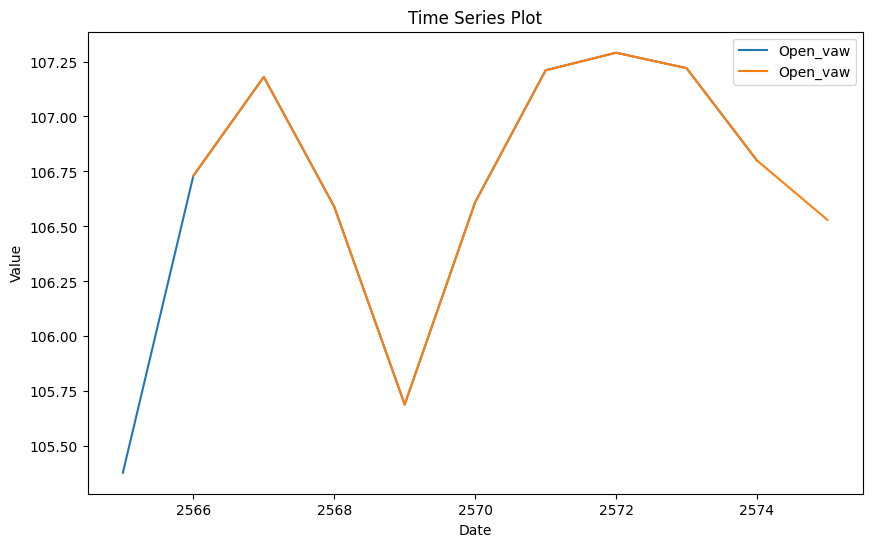

In [ ]:
print(Test_Fragmented[5]['Open_vaw'])
print(Test_Fragmented[6]['Open_vaw'])
# Plot the time series data using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(Test_Fragmented[5].index, Test_Fragmented[5]['Open_vaw'], label='Open_vaw')
plt.plot(Test_Fragmented[6].index,Test_Fragmented[6]['Open_vaw'], label='Open_vaw')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

In [ ]:


# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class Simple_LSTM(nn.Module):
  def __init__(self,
               input_size : int = 35,
               hidden_size : int = 20,
               output_size : int = 6,
               num_layers : int =  5,
               activation_function = nn.Softmax(dim = 1)):  #softmax activation function in order to get multiclass probability
    # Define RNN or LSTM architecture
    super().__init__()
    self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)

    self.activation_function = activation_function

    self.last_linear = nn.Linear(hidden_size,output_size)

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    last_hidden_state = last_states[0][-1, :, :]
    # Get sequence label probability using the last hidden state
    next_prediction = self.last_linear(last_hidden_state)
    return next_prediction


In [ ]:
import torch
import torch.nn as nn

class Encoder_LSTM(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embedding_dim: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 num_layers: int = 5,
                 activation_function=nn.Softmax(dim=1)):
        super(Encoder_LSTM, self).__init__()

        # Define embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        # Define activation function
        self.activation_function = activation_function

        # Define the final linear layer
        self.last_linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        # Encode the input sequences
        embedded = self.embedding(X)

        # Pass through LSTM
        _, (last_hidden_state, _) = self.lstm(embedded)

        # Get last hidden state for last layer
        last_hidden_state = last_hidden_state[-1, :, :]

        # Get sequence label probability using the last hidden state
        next_prediction = self.last_linear(last_hidden_state)
        next_prediction = self.activation_function(next_prediction)

        return next_prediction

# Example usage
# vocab_size = 5000  # Size of vocabulary
# embedding_dim = 50  # Dimension of embedding vectors
# input_size = embedding_dim  # Input size to LSTM (should match embedding_dim)
# hidden_size = 20  # Number of hidden units in LSTM
# output_size = 6  # Number of output classes
# num_layers = 5  # Number of LSTM layers

# model = Encoder_LSTM(vocab_size, embedding_dim, input_size, hidden_size, output_size, num_layers)
# print(model)


In [3]:
def train_simple_LSTM(X_train, Y_train, model, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
      optimizer.zero_grad()
      output = model(X_train)
      loss = loss_func(output.log(),Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)

In [4]:
import torch
import torch.nn.functional as F

def pad_tensor_list(tensor_list):
    # Determine the maximum length of the first dimension
    max_length = max(tensor.size(0) for tensor in tensor_list)

    # Pad each tensor in the list to have the same length along the first dimension
    padded_tensors = [F.pad(tensor, (0, 0, 0, max_length - tensor.size(0))) for tensor in tensor_list]

    # Stack the padded tensors
    return torch.stack(padded_tensors)

# Function to convert, pad, and stack tensors, with shape checks
def process_fragments(fragments):
    tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in fragments]

    # Ensure all tensors are 2D
    for i, tensor in enumerate(tensor_list):
        if tensor.dim() == 1:
            tensor_list[i] = tensor.unsqueeze(1)

    return pad_tensor_list(tensor_list)

# Process Train_Fragmented
X_train = process_fragments(Train_Fragmented)

# Process Train_Labels
Y_train = process_fragments(Train_Labels)

# Process Test_Fragmented
X_test = process_fragments(Test_Fragmented)

# Process Test_Labels
Y_test = process_fragments(Test_Labels)


NameError: name 'Train_Fragmented' is not defined

In [ ]:

print(X_train.shape)
print(Y_train.shape)

torch.Size([2560, 10, 35])
torch.Size([2560, 6, 1])


In [ ]:
X_train_pt = X_train.float().cuda()
Y_train_pt = Y_train.float().cuda()
X_test_pt = X_test.float().cuda()
Y_test_pt = Y_test.float().cuda()

In [ ]:

input_size = 35
hidden_size = 256
num_layers = 5
output_size = 6

# Define model, loss function, and optimizer
model = Simple_LSTM(input_size=input_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers).cuda()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 4000
loss_its = []
for iter in range(num_epochs):
  optimizer.zero_grad()
  output = model(X_train_pt)
  loss = loss_func(output,Y_train_pt)
  loss_its.append(loss.item())
  loss.backward()
  optimizer.step()

  if( iter%100 == 0):
    print(f'Final loss: {loss.item()}')

loss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)


Final loss: 4202.9775390625
Final loss: 1645.2044677734375
Final loss: 721.83642578125
Final loss: 407.989013671875
Final loss: 317.73895263671875
Final loss: 295.0257568359375
Final loss: 290.0235290527344
Final loss: 289.0812683105469
Final loss: 288.93310546875
Final loss: 288.9140625
Final loss: 288.912109375
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Final loss: 288.91192626953125
Fin

# Histogram

In [1]:
Y_predicted = model(X_test_pt).cpu().detach().numpy()
Y = Y_test_pt.cpu().detach().numpy()
print(Y_predicted)

NameError: name 'model' is not defined

In [ ]:
file_path = os.path.join(myDrive,'Y_predicted.csv')
pd.DataFrame(Y_predicted).to_csv(file_path, index=False)

Y_predicted shape: (640, 6)
Y shape after squeezing: (640, 6)


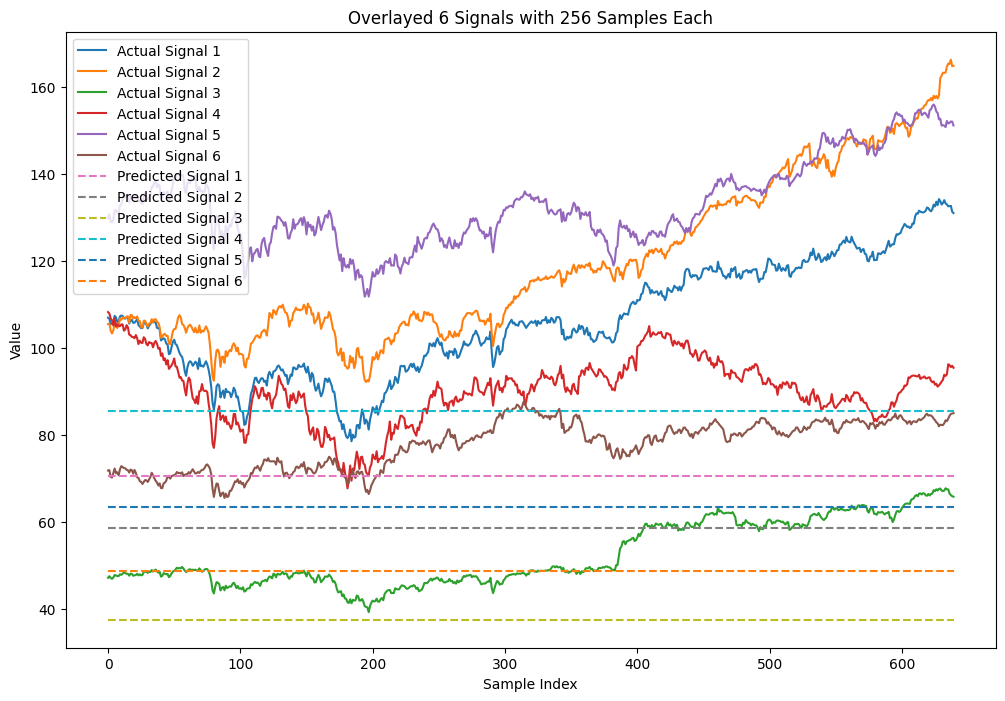

In [ ]:
import matplotlib.pyplot as plt

# Example arrays for Y_predicted and Y
# Ensure these are defined as per your actual data
# Y_predicted = np.random.randn(640, 6)  # Example: If Y_predicted is a 2D array
# Y = np.random.randn(640, 6, 1)  # Example: If Y is a 3D array

# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y.squeeze()

# Check the shapes (for debugging purposes)
print("Y_predicted shape:", Y_predicted.shape)
print("Y shape after squeezing:", Y_squeezed.shape)

# Plot the actual signals
plt.figure(figsize=(12, 8))
for i in range(Y_squeezed.shape[1]):
    plt.plot(Y_squeezed[:, i], label=f"Actual Signal {i+1}")

# Ensure Y_predicted is compatible for plotting
if Y_predicted.ndim == 1:
    # If Y_predicted is 1D, we plot it directly
    plt.plot(Y_predicted, label="Predicted Signal", linestyle='--')
elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
    # If Y_predicted is 2D, plot each predicted signal
    for i in range(Y_predicted.shape[1]):
        plt.plot(Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")

plt.title('Overlayed 6 Signals with 256 Samples Each')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


ValueError: x and y can be no greater than 2D, but have shapes (640,) and (640, 6, 1)

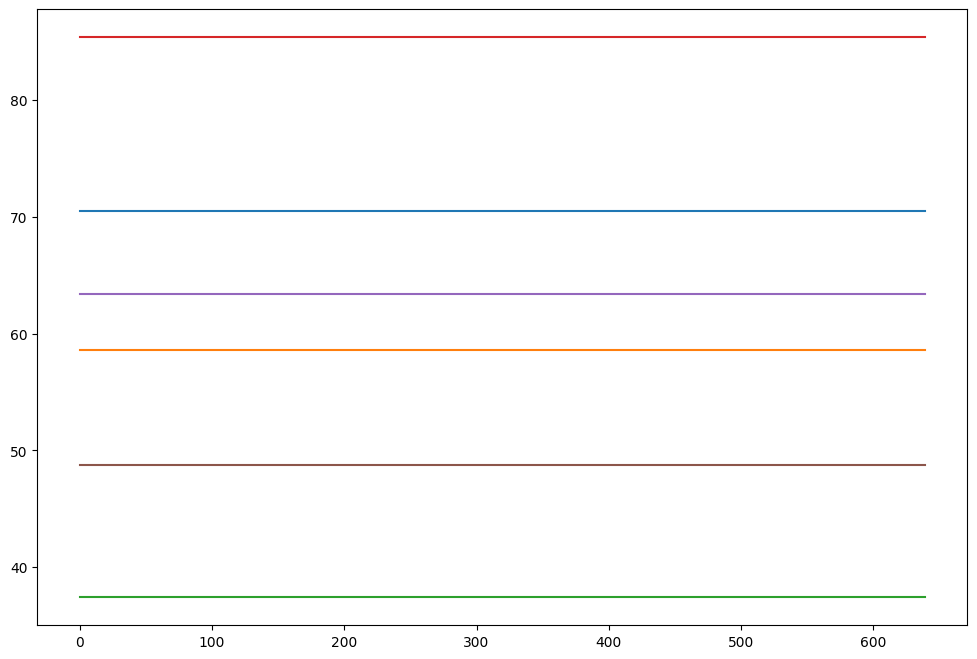

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(Y_predicted)
plt.plot(Y)
plt.title('Overlayed 6 Signals with 256 Samples Each')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()